In [1]:
import pandas as pd

In [2]:
data_dir = './data/trial1/'

In [3]:
pwd

'D:\\Documents\\Udacity\\Self-Driving Car Engineer Nanodegree\\Computer Vision Fundamentals\\Projects\\Project 4\\CarND-Behavioral-Cloning-P3'

In [4]:
df = pd.read_csv(data_dir+'driving_log.csv', names=['center_cam', 'left_cam', 'right_cam', 'steering', 'throttle', 'brake', 'speed'])

In [5]:
df.head()

,center_cam,left_cam,right_cam,steering,throttle,brake,speed
0,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,0.0,0.0,0,0.000052
1,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,0.0,0.0,0,0.000053
2,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,0.0,0.0,0,0.000053
3,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,0.0,0.0,0,0.000053
4,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,D:\Documents\Udacity\Self-Driving Car Engineer...,0.0,0.0,0,0.000054


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   center_cam  685 non-null    object 
 1   left_cam    685 non-null    object 
 2   right_cam   685 non-null    object 
 3   steering    685 non-null    float64
 4   throttle    685 non-null    float64
 5   brake       685 non-null    int64  
 6   speed       685 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 37.6+ KB


In [7]:
df_clean = df.copy()

In [8]:
df_clean.iloc[:,0:3] = df_clean.iloc[:,0:3].apply(lambda x: data_dir + 'IMG/' + x.str.split('\\').str[-1])

In [9]:
df_clean.head()

,center_cam,left_cam,right_cam,steering,throttle,brake,speed
0,./data/trial1/IMG/center_2021_01_04_23_37_20_5...,./data/trial1/IMG/left_2021_01_04_23_37_20_539...,./data/trial1/IMG/right_2021_01_04_23_37_20_53...,0.0,0.0,0,0.000052
1,./data/trial1/IMG/center_2021_01_04_23_37_20_6...,./data/trial1/IMG/left_2021_01_04_23_37_20_605...,./data/trial1/IMG/right_2021_01_04_23_37_20_60...,0.0,0.0,0,0.000053
2,./data/trial1/IMG/center_2021_01_04_23_37_20_6...,./data/trial1/IMG/left_2021_01_04_23_37_20_675...,./data/trial1/IMG/right_2021_01_04_23_37_20_67...,0.0,0.0,0,0.000053
3,./data/trial1/IMG/center_2021_01_04_23_37_20_7...,./data/trial1/IMG/left_2021_01_04_23_37_20_746...,./data/trial1/IMG/right_2021_01_04_23_37_20_74...,0.0,0.0,0,0.000053
4,./data/trial1/IMG/center_2021_01_04_23_37_20_8...,./data/trial1/IMG/left_2021_01_04_23_37_20_814...,./data/trial1/IMG/right_2021_01_04_23_37_20_81...,0.0,0.0,0,0.000054


In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [11]:
images = []
measurements = []

In [12]:
df_clean['center_cam'].apply(lambda x: images.append(mpimg.imread(x)));
df_clean['steering'].apply(lambda x: measurements.append(x));

In [13]:
import numpy as np

In [14]:
X_train = np.array(images)
y_train = np.array(measurements)

# Training

In [15]:
import tensorflow as tf

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Flatten, Dense, Conv2D, MaxPool2D, Dropout  

In [17]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [18]:
X_train.shape

(685, 160, 320, 3)

In [19]:
model = Sequential()
model.add(Flatten(input_shape=(160,320,3)))
model.add(Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
import cv2

In [21]:
modified_images = []

In [22]:
scale_percent = 25 # percent of original size
width = int(X_train[0].shape[1] * scale_percent / 100)
height = int(X_train[0].shape[0] * scale_percent / 100)
dim = (width, height)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for image in X_train:
    normalized = image.copy()
    normalized[:,:,0] = clahe.apply(normalized[:,:,0])
    normalized[:,:,1] = clahe.apply(normalized[:,:,1])
    normalized[:,:,2] = clahe.apply(normalized[:,:,2])
    grayscale = cv2.cvtColor(normalized, cv2.COLOR_RGB2GRAY)
    downscaled = cv2.resize(grayscale, dim, interpolation=cv2.INTER_AREA)
    modified_images.append(downscaled)
# plt.imshow(cv2.resize(X_train[0], dim, interpolation=cv2.INTER_AREA))

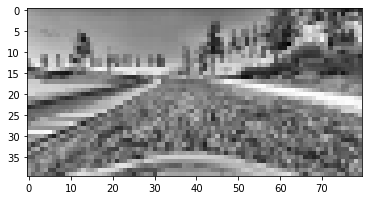

In [23]:
plt.imshow(modified_images[100], cmap='gray')

In [24]:
X_train_modified = np.array(modified_images)
# Adding a dimension for Keras processing purposes
X_train_modified = np.expand_dims(X_train_modified, 3)

In [54]:
tf.keras.backend.clear_session()

In [55]:
model = Sequential()
# Input Layer
model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(height, width, 1)))
# model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(160,320,1)))
# Convolution 1
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(strides=(1,1)))
# Convolution 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(strides=(1,1)))
# Convolution 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(strides=(1,1)))
# Flatten and Dropout
model.add(Flatten())
model.add(Dropout(0.25))
# Fully Connected 1
model.add(Dense(120, activation='relu'))
# Fully Connected 2 with Dropout
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.5))
# Output
model.add(Dense(1));

In [47]:
# model.compile(loss='mse', optimizer='adam')
# history = model.fit(X_train_modified, y_train, epochs=1, batch_size=256, validation_split=0.2, shuffle=True)

Train on 548 samples, validate on 137 samples
548/548 [==============================] - 7s 13ms/sample - loss: 55.6031 - val_loss: 0.4831


In [51]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs\\fit\\"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [52]:
stopper = EarlyStopping(monitor='val_acc', min_delta=0.0003, patience=5)

In [61]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_modified, y_train, epochs=100, batch_size=200, validation_split=0.2, shuffle=True, callbacks=[tensorboard_callback, stopper])

Train on 548 samples, validate on 137 samples
Epoch 1/100
548/548 [==============================] - 6s 11ms/sample - loss: 0.2804 - acc: 0.0967 - val_loss: 0.2282 - val_acc: 0.0657
Epoch 2/100
548/548 [==============================] - 5s 9ms/sample - loss: 0.0051 - acc: 0.1186 - val_loss: 0.2285 - val_acc: 0.0657
Epoch 3/100
548/548 [==============================] - 5s 9ms/sample - loss: 0.0043 - acc: 0.1186 - val_loss: 0.2234 - val_acc: 0.0657
Epoch 4/100
548/548 [==============================] - 5s 9ms/sample - loss: 0.0035 - acc: 0.1186 - val_loss: 0.2203 - val_acc: 0.0657
Epoch 5/100
548/548 [==============================] - 5s 9ms/sample - loss: 0.0034 - acc: 0.1186 - val_loss: 0.2275 - val_acc: 0.0657
Epoch 6/100
548/548 [==============================] - 5s 9ms/sample - loss: 0.0040 - acc: 0.1186 - val_loss: 0.2217 - val_acc: 0.0657


In [62]:
model.save('model.h5')

In [31]:
from tensorflow.keras.models import load_model

In [32]:
model = load_model('model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [69]:
model.predict(np.expand_dims(X_train_modified[100], axis=0))

array([[-0.03223201]], dtype=float32)

In [26]:
# %run drive.py model.h5